## Import packages and check hardware

In [ ]:
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
import time
import copy
from os import path
import sys

In [ ]:
## One way to save files to the google drive
## Executing this cell opens a dialog to choose a google account and confirm permissions.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Check to see if gpu is available. If it is, use it; else use the cpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print('Using GPU')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.FloatTensor')
    print('No GPU found, using cpu')

Using GPU


In [ ]:
## Get info about the CPU (and GPU if available)...
!cat /proc/cpuinfo | grep "model name"
!nvidia-smi -L

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
GPU 0: Tesla T4 (UUID: GPU-c14f333b-5ed0-8d23-e46a-ded745982bfe)


## Solve a simple first order ODE
$$ \dot x(t) + \lambda x(t) = 0 $$

Define some helper functions

In [ ]:
# Calculate the derivatice with auto-differention
def dfx(x,f):
    return grad([f], [x], grad_outputs=torch.ones(x.shape), create_graph=True)[0]

## Different options for parametrizing the solution to
## enforce the initial conditions
def parametricSolutions(t, nn, X0):
    # parametric solutions
    t0, x0  = X0[0],X0[1]  ## initial conditions x(t0) = x0
    N1  = nn(t)
    dt =t-t0

    f=dt
#    f = (1-torch.exp(-dt))
    x_hat  = x0  + f*N1
    return x_hat

## Define the loss function using the differential equation
def Eqs_Loss(t,x1, X0):
    xdot = dfx(t,x1)
    lam = X0[2]
    f1  = xdot + lam*x1
    L  = (f1.pow(2)).mean()
    return L

Network architecture

In [ ]:
# A two hidden layer NN, 1 input & 1 output
class odeNet(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(odeNet,self).__init__()

        # Define the Activation
        self.actF = torch.nn.Sigmoid()

        # define layers
        self.Lin_1   = torch.nn.Linear(1, D_hid)
        self.Lin_2   = torch.nn.Linear(D_hid, D_hid)
        self.Lin_out = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        # layer 1
        l = self.Lin_1(t)
        h = self.actF(l)
        # layer 2
        l = self.Lin_2(h)
        h = self.actF(l)
        # output layer
        netOut = self.Lin_out(h)
        return netOut


In [ ]:
# Train the NN
def run_odeNet(X0, tf, num_neurons, max_epochs, n_train, lr, loadWeights=False, minLoss=1e-3,
               PATH ="./model1"):

    fc0 = odeNet(num_neurons)
    fc1 =  copy.deepcopy(fc0) # fc1 is a deepcopy of the network with the lowest training loss
    # optimizer
    betas = [0.999, 0.9999]

    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = []
    Llim =  1
    t0=X0[0]

## Load weights from previous training (if loadWeights=True and PATH file exists)
    if path.exists(PATH) and loadWeights==True:
        checkpoint = torch.load(PATH)
        fc0.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        tt = checkpoint['epoch']
        Ltot = checkpoint['loss']
        fc0.train()

## TRAINING ITERATION
    time_start = time.time()
    for epoch in range(max_epochs):
        loss = 0.0
        t = torch.Tensor(n_train,1).uniform_(t0, tf).sort(dim=0)[0]
        t.requires_grad = True

        x = parametricSolutions(t,fc0,X0)

        Ltot = Eqs_Loss(t,x, X0)

# OPTIMIZER
        Ltot.backward(retain_graph=False); #True
        optimizer.step();
        loss += Ltot.cpu().data.numpy()

        optimizer.zero_grad()

# keep the loss function history
        Loss_history.append(loss)

#Keep the best model (lowest loss) by using a deep copy
        if  epoch > 0.8*max_epochs  and Ltot < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=Ltot

# break the training after a thresold of accuracy
        if Ltot < minLoss :
            fc1 =  copy.deepcopy(fc0)
            print('Reach minimum requested loss')
            break

    time_end = time.time()
    runTime = time_end - time_start


    torch.save({
    'epoch': epoch,
    'model_state_dict': fc1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': Ltot,
    }, PATH)

    return fc1, Loss_history, runTime


In [ ]:
def trainModel(X0, t_max, num_neurons, max_epochs, n_train, lr,  loadWeights=True, minLoss=1e-6, showLoss=True,
               PATH ="./"):
    model, loss, runTime = run_odeNet(X0, t_max, num_neurons, max_epochs, n_train, lr,  loadWeights=loadWeights, minLoss=minLoss)

    np.savetxt(PATH+'saved-loss.txt',loss)

    if showLoss==True :
        print('Training time (minutes):', runTime/60)
        print('Training Loss: ',  loss[-1] )
        plt.figure()
        plt.loglog(loss,'-b',alpha=0.975);
        plt.tight_layout()
        plt.ylabel('Loss');plt.xlabel('t')
        plt.savefig('saved_fig.png')
    return model


def loadModel(num_neurons, PATH ="./"):
    if path.exists(PATH):
        fc0 = odeNet(num_neurons)
        checkpoint = torch.load(PATH)
        fc0.load_state_dict(checkpoint['model_state_dict'])
        fc0.train(); # or model.eval
    else:
        print('Warning: There is not any trained model. Terminate')
        sys.exit()

    return fc0


Training time (minutes): 0.09479180177052816
Training Loss:  0.01002370472997427


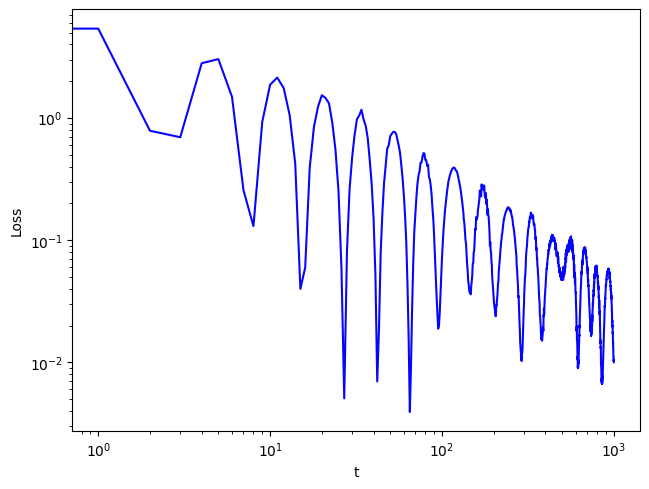

In [ ]:
## TRAIN THE NETWORK.

## Set the time range and the training points N
t0, t_max, N = 0.,  2*np.pi, 500;
## Set the initial conditions; lambda is a parameter in the differential equation
t0 = 0
x0 = 1
lam = 1
X0 = [t0, x0,lam]  ## list to pass to the network

## Set the training parameters
t_max = 2*np.pi
n_train = 500  ## number of training points per epoch
num_neurons = 80  ## number of neurons per hidden layer
max_epochs = int( 1e3 )  ## maximum number of epochs
lr = 8e-3  ## learning rate (shouldn't have to change for beginning examples)

## Train a model from scratch
model = trainModel(X0, t_max, num_neurons, max_epochs, n_train, lr,  loadWeights=True, minLoss=1e-6, showLoss=True)

## Restart training from a partially trained model
#model = trainModel(X0, t_max, num_neurons, max_epochs, n_train, lr,  loadWeights=True, minLoss=1e-6, showLoss=True, PATH ="/content/gdrive/MyDrive/NN_for_Materials/Templates/saved_models/model1")

## load a pretrained model from a file
#model = loadModel(num_neurons, PATH ="/content/gdrive/MyDrive/NN_for_Materials/Templates/saved_models/model1")

Test the predictions

In [ ]:
## The network can be evaluated at different points from the training.
extrap = 2
nTest = 1000 ; t_max_test = extrap * t_max
tTest = torch.linspace(t0,t_max_test,nTest)

tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.cpu().detach().numpy()


xTest=parametricSolutions(tTest,model,X0)
xdotTest=dfx(tTest,xTest)

xTest=xTest.cpu().data.numpy()
xdotTest=xdotTest.cpu().data.numpy()


Ground Truth solution

In [ ]:
## Check that this is the correct analytic solution
x_exact = x0*np.exp(-lam*t_net)
xdot_exact = -lam*x0*np.exp(-lam*t_net)

Make some plots

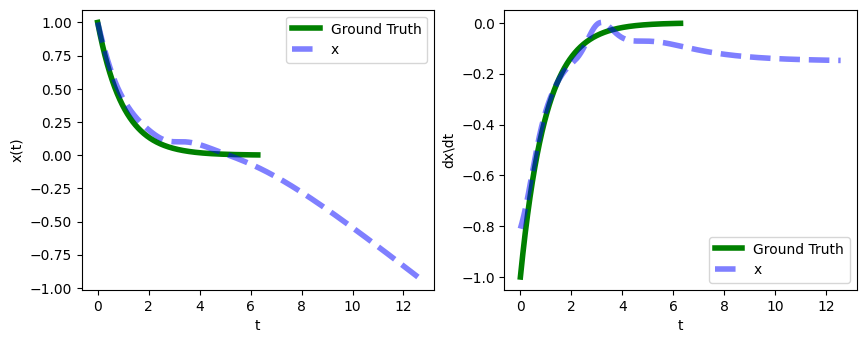

In [ ]:
################
# Make the plots
#################

lineW = 4 # Line thickness
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(t_net/extrap, x_exact,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xTest,'--b', label='x',linewidth=lineW, alpha=.5);
plt.ylabel('x(t)');plt.xlabel('t')
plt.legend()


plt.subplot(2,2,2)
plt.plot(t_net/extrap, xdot_exact,'-g', label='Ground Truth', linewidth=lineW);
plt.plot(t_net, xdotTest,'--b', label='x',linewidth=lineW, alpha=.5);
plt.ylabel('dx\dt');plt.xlabel('t')
plt.legend()

#plt.savefig('simpleExp.png')  ## choose the correct path


Play around with this example to make sure you understand what the different pieces are doing.    
Things to consider:
* Try changing the initial conditions.
* Try changing the parameter $\lambda$.
* Does the model train with fewer hidden layers? fewer nodes per layer?
* How many (or few) training points do you need?
* What does the network solution predict outside the training window?
* Why is there .cpu().data.numpy()?

## Try a 2nd order ODE
$$ \ddot x(t) + \omega^2 x(t) = 0 $$

Don't hesitate to recycle code from the previous example. Try to keep it neat and well documented.      
Things to consider:
* What initial conditions are needed?
* Can you instead solve a boundary value problem?
* How many hidden layers are needed?
* How few neurons can you get away with?
* How is the training affected by the parameter $\omega$?
* What does the network solution predict outside the training window?